<a href="https://colab.research.google.com/github/jeanbai/Spam-Emails-Detection/blob/main/Questions_and_Answers_BERT_squad_NLP_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Questions and Answers BERT Squad Transform Algorithm

**What is BERT?**
BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.

>* Encoder Representations:language modeling system, pre-trained with unlabeled data. Then fine_tuning(Google)
>* From Tranformer: based on powerful NLP algotrithm. Defines the arthetecture of BERT(sequense to sequese)
>* Bidirectional: use with left and right context when dealing with a word. Defines the training process.(predict words and acceess the previus words)

**How BERT works?
As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).

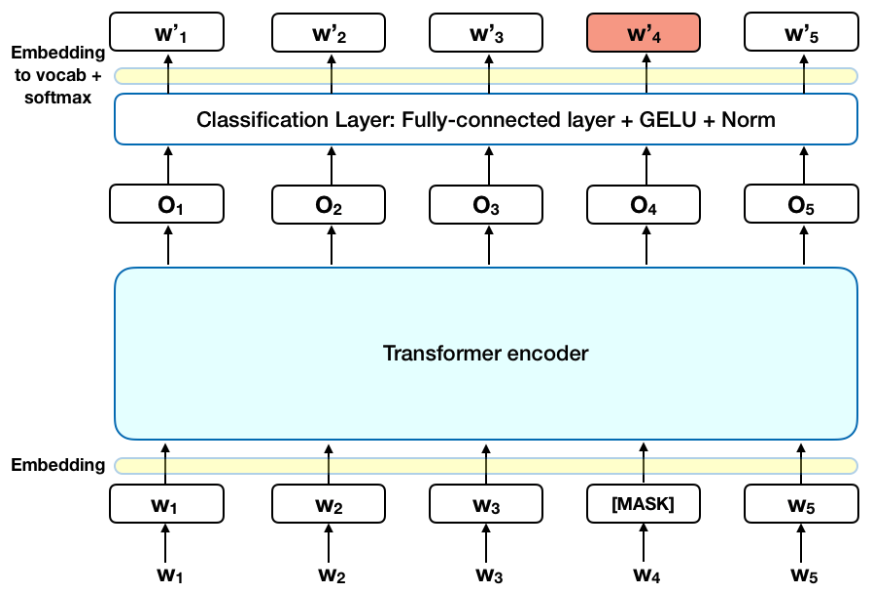

To help the model distinguish between the two sentences in training, the input is processed in the following way before entering the model:
>*A [CLS] token is inserted at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.

>*A sentence embedding indicating Sentence A or Sentence B is added to each token. Sentence embeddings are similar in concept to token embeddings with a vocabulary of 2.

>*A positional embedding is added to each token to indicate its position in the sequence. The concept and implementation of positional embedding are presented in the Transformer paper.


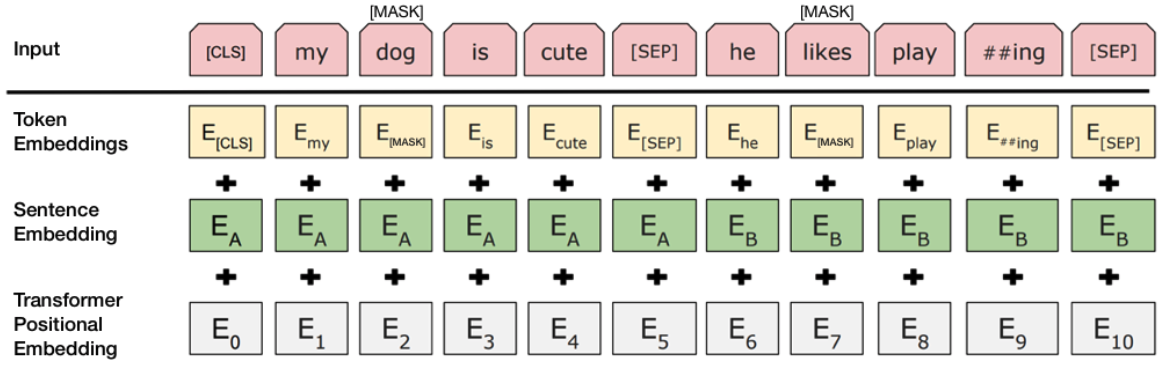

# Stage 1: Importing dependencies



In [4]:
import tensorflow_hub as hub

from official.nlp.bert.tokenization import FullTokenizer
from official.nlp.bert.input_pipeline import create_squad_dataset
from official.nlp.data.squad_lib import generate_tf_record_from_json_file

from official.nlp import optimization

from official.nlp.data.squad_lib import read_squad_examples
from official.nlp.data.squad_lib import FeatureWriter
from official.nlp.data.squad_lib import convert_examples_to_features
from official.nlp.data.squad_lib import write_predictions

In [5]:
import numpy as np
import math
import random
import time 
import json
import collections
import os

from google.colab import drive

# Stage 2: Data preprocessing

Data source: https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/

Use the Version 1.1 dev.set

Envirnment: Colab TPU


In [6]:
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
input_meta_data = generate_tf_record_from_json_file(
    "/content/drive/MyDrive/projects/BERT/train-v1.1.json",
    "/content/drive/My Drive/projects/BERT/vocab.txt",
    "/content/drive/My Drive/projects/BERT/train-v1.1.tf_record")

In [8]:
with tf.io.gfile.GFile("/content/drive/My Drive/projects/BERT/train_meta_data", "w") as writer:
    writer.write(json.dumps(input_meta_data, indent=4) + "\n")

In [ ]:
BATCH_SIZE = 4

train_dataset = create_squad_dataset(
    "/content/drive/My Drive/projects/BERT/train-v1.1.tf_record",
    input_meta_data['max_seq_length'], # max_seq_length is 384 
    BATCH_SIZE,
    is_training=True)

# Stage 3: Model building






## Squad layer 
Define Squad layers

In [10]:
class BertSquadLayer(tf.keras.layers.Layer):

  def __init__(self):
    super(BertSquadLayer, self).__init__()
    self.final_dense = tf.keras.layers.Dense(
        units=2, #add one layer the beginning and one layer for the end
        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))

  def call(self, inputs):
    logits = self.final_dense(inputs) # (batch_size, seq_len, 2)

    logits = tf.transpose(logits, [2, 0, 1]) # (2, batch_size, seq_len)
    unstacked_logits = tf.unstack(logits, axis=0) # [(batch_size, seq_len), (batch_size, seq_len)] 
    return unstacked_logits[0], unstacked_logits[1]#represent the first layer and the last layer

## Whole model

In [19]:
class BERTSquad(tf.keras.Model):
    
    def __init__(self,
                 name="bert_squad"):
        super(BERTSquad, self).__init__(name=name)
        
        self.bert_layer = hub.KerasLayer(
            "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
            trainable=True)
        
        self.squad_layer = BertSquadLayer()
    
    def apply_bert(self, inputs):
       _ , sequence_output = self.bert_layer([inputs["input_word_ids"],
                                               inputs["input_mask"],
                                               inputs["input_type_ids"]])
       
       return sequence_output
        

    def call(self, inputs):
        seq_output = self.apply_bert(inputs)

        start_logits, end_logits = self.squad_layer(seq_output)

        
        return start_logits, end_logits

# Stage 4: Training

## Creating the AI

In [20]:
TRAIN_DATA_SIZE = 88641
NB_BATCHES_TRAIN = 2000
BATCH_SIZE = 4
NB_EPOCHS = 3
INIT_LR = 5e-5 #to optimaze the result
WARMUP_STEPS = int(NB_BATCHES_TRAIN * 0.1) 

In [21]:
train_dataset_light = train_dataset.take(NB_BATCHES_TRAIN)

In [22]:
bert_squad = BERTSquad()

In [23]:
optimizer = optimization.create_optimizer(
    init_lr=INIT_LR,
    num_train_steps=NB_BATCHES_TRAIN,
    num_warmup_steps=WARMUP_STEPS)

In [24]:
def squad_loss_fn(labels, model_outputs):
    start_positions = labels['start_positions']
    end_positions = labels['end_positions']
    start_logits, end_logits = model_outputs

    start_loss = tf.keras.backend.sparse_categorical_crossentropy(
        start_positions, start_logits, from_logits=True)
    end_loss = tf.keras.backend.sparse_categorical_crossentropy(
        end_positions, end_logits, from_logits=True)
    
    total_loss = (tf.reduce_mean(start_loss) + tf.reduce_mean(end_loss)) / 2

    return total_loss

train_loss = tf.keras.metrics.Mean(name="train_loss")

In [25]:
next(iter(train_dataset_light))

({'input_mask': <tf.Tensor: shape=(4, 384), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
  'input_type_ids': <tf.Tensor: shape=(4, 384), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
  'input_word_ids': <tf.Tensor: shape=(4, 384), dtype=int32, numpy=
  array([[ 101, 2054, 2106, ...,    0,    0,    0],
         [ 101, 1996, 8840, ...,    0,    0,    0],
         [ 101, 2129, 2116, ...,    0,    0,    0],
         [ 101, 2054, 7017, ...,    0,    0,    0]], dtype=int32)>},
 {'end_positions': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 33, 232,  36, 122], dtype=int32)>,
  'start_positions': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 30, 232,  33, 119], dtype=int32)>})

In [26]:
bert_squad.compile(optimizer,
                   squad_loss_fn)

In [27]:
checkpoint_path = "./drive/My Drive/projects/BERT/ckpt_bert_squad/"

ckpt = tf.train.Checkpoint(bert_squad=bert_squad)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

## Custom training

In [28]:
for epoch in range(NB_EPOCHS):
    print("Start of epoch {}".format(epoch+1))
    start = time.time()
    
    train_loss.reset_states()
    
    for (batch, (inputs, targets)) in enumerate(train_dataset_light):
        with tf.GradientTape() as tape:
            model_outputs = bert_squad(inputs)
            loss = squad_loss_fn(targets, model_outputs)
        
        gradients = tape.gradient(loss, bert_squad.trainable_variables)
        optimizer.apply_gradients(zip(gradients, bert_squad.trainable_variables))
        
        train_loss(loss)
        
        if batch % 50 == 0:
            print("Epoch {} Batch {} Loss {:.4f}".format(
                epoch+1, batch, train_loss.result()))
        
     #if batch % 500 == 0:
            #ckpt_save_path = ckpt_manager.save()
            #print("Saving checkpoint for epoch {} at {}".format(epoch+1,
            #                                                    ckpt_save_path))
    print("Time taken for 1 epoch: {} secs\n".format(time.time() - start))

Start of epoch 1
Epoch 1 Batch 0 Loss 6.1315
Epoch 1 Batch 50 Loss 5.8105
Epoch 1 Batch 100 Loss 5.2867
Epoch 1 Batch 150 Loss 4.6864
Epoch 1 Batch 200 Loss 4.1981
Epoch 1 Batch 250 Loss 3.8128
Epoch 1 Batch 300 Loss 3.5374
Epoch 1 Batch 350 Loss 3.3734
Epoch 1 Batch 400 Loss 3.1759
Epoch 1 Batch 450 Loss 2.9787
Epoch 1 Batch 500 Loss 2.8545
Epoch 1 Batch 550 Loss 2.7227
Epoch 1 Batch 600 Loss 2.6321
Epoch 1 Batch 650 Loss 2.5448
Epoch 1 Batch 700 Loss 2.4820
Epoch 1 Batch 750 Loss 2.4089
Epoch 1 Batch 800 Loss 2.3467
Epoch 1 Batch 850 Loss 2.3086
Epoch 1 Batch 900 Loss 2.2501
Epoch 1 Batch 950 Loss 2.1986
Epoch 1 Batch 1000 Loss 2.1384
Epoch 1 Batch 1050 Loss 2.0900
Epoch 1 Batch 1100 Loss 2.0371
Epoch 1 Batch 1150 Loss 1.9879
Epoch 1 Batch 1200 Loss 1.9456
Epoch 1 Batch 1250 Loss 1.9219
Epoch 1 Batch 1300 Loss 1.9049
Epoch 1 Batch 1350 Loss 1.8922
Epoch 1 Batch 1400 Loss 1.8696
Epoch 1 Batch 1450 Loss 1.8437
Epoch 1 Batch 1500 Loss 1.8232
Epoch 1 Batch 1550 Loss 1.8014
Epoch 1 Batch 

# Stage 5: Evaluation

## Prepare evaluation

Get the dev set in the session

In [34]:
eval_examples = read_squad_examples(
    "/content/drive/My Drive/projects/BERT/dev-v1.1.json",
    is_training=False,
    version_2_with_negative=False)

Define the function that will write the tf_record file for the dev set

In [35]:
eval_writer = FeatureWriter(
    filename=os.path.join("/content/drive/My Drive/projects/BERT/",
                          "eval.tf_record"),
    is_training=False)

Create a tokenizer for future information needs

In [36]:
my_bert_layer = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
    trainable=False)
vocab_file = my_bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = my_bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

Define the function that add the features (feature is a protocol in tensorflow) to our eval_features list

In [37]:
def _append_feature(feature, is_padding):
    if not is_padding:
        eval_features.append(feature)
    eval_writer.process_feature(feature)

Create the eval features and the writes the tf.record file

In [38]:
eval_features = []
dataset_size = convert_examples_to_features(
    examples=eval_examples,
    tokenizer=tokenizer,
    max_seq_length=384,
    doc_stride=128,
    max_query_length=64,
    is_training=False,
    output_fn=_append_feature,
    batch_size=4)

In [39]:
eval_writer.close()

Load the ready-to-be-used dataset to our session

In [ ]:
BATCH_SIZE = 4

eval_dataset = create_squad_dataset(
    "/content/drive/My Drive/projects/BERT/eval.tf_record",
    384,#input_meta_data['max_seq_length'],
    BATCH_SIZE,
    is_training=False)

## Making the predictions

Defines a certain type of collection (like a dictionary)

In [41]:
RawResult = collections.namedtuple("RawResult",
                                   ["unique_id", "start_logits", "end_logits"])

Returns each element of batched output at a time

In [42]:
def get_raw_results(predictions):
    for unique_ids, start_logits, end_logits in zip(predictions['unique_ids'],
                                                    predictions['start_logits'],
                                                    predictions['end_logits']):
        yield RawResult(
            unique_id=unique_ids.numpy(),
            start_logits=start_logits.numpy().tolist(),
            end_logits=end_logits.numpy().tolist())

Let's make our predictions!

In [43]:
all_results = []
for count, inputs in enumerate(eval_dataset):
    x, _ = inputs
    unique_ids = x.pop("unique_ids")
    start_logits, end_logits = bert_squad(x, training=False)
    output_dict = dict(
        unique_ids=unique_ids,
        start_logits=start_logits,
        end_logits=end_logits)
    for result in get_raw_results(output_dict):
        all_results.append(result)
    if count % 100 == 0:
        print("{}/{}".format(count, 2709))

0/2709
100/2709
200/2709
300/2709
400/2709
500/2709
600/2709
700/2709
800/2709
900/2709
1000/2709
1100/2709
1200/2709
1300/2709
1400/2709
1500/2709
1600/2709
1700/2709
1800/2709
1900/2709
2000/2709
2100/2709
2200/2709
2300/2709
2400/2709
2500/2709
2600/2709
2700/2709


Write the predictions in a json file that will work with the evaluation script

In [44]:
output_prediction_file = "/content/drive/My Drive/projects/BERT/predictions.json"
output_nbest_file = "/content/drive/My Drive/projects/BERT/nbest_predictions.json"
output_null_log_odds_file = "/content/drive/My Drive/projects/BERT/null_odds.json"

write_predictions(
    eval_examples,
    eval_features,
    all_results,
    20,
    30,
    True,
    output_prediction_file,
    output_nbest_file,
    output_null_log_odds_file,
    verbose=False)

## Home-made prediction

### Input dict creation

Concatenate the question and the context, separated by a `["SEP"]`, after tokenization, as it has been made for the training set.

The important thing is that we want our answer to start with a real word and to end with a real word. The word "ecologically" being tokenized as `["ecological", "##ly"]`, if the ending token is `["ecological"]` we want to use "ecologically" as the ending word (same thing if the ending token is `["##ly"]`). That is why we first split our context into words, and then into tokens, remembering to which word each token belongs to (see the `tokenize_context()` function).

#### Utils

In [45]:
my_bert_layer = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
    trainable=False)
vocab_file = my_bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = my_bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [46]:
def is_whitespace(c):
    '''
    Tell if a chain of characters corresponds to a whitespace or not.
    '''
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [47]:
def whitespace_split(text):
    '''
    Take a text and return a list of "words" by splitting it according to
    whitespaces.
    '''
    doc_tokens = []
    prev_is_whitespace = True
    for c in text:
        if is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                doc_tokens.append(c)
            else:
                doc_tokens[-1] += c
            prev_is_whitespace = False
    return doc_tokens

In [48]:
def tokenize_context(text_words):
    '''
    Take a list of words (returned by whitespace_split()) and tokenize each word
    one by one. Also keep track, for each new token, of its original word in the
    text_words parameter.
    '''
    text_tok = []
    tok_to_word_id = []
    for word_id, word in enumerate(text_words):
        word_tok = tokenizer.tokenize(word)
        text_tok += word_tok
        tok_to_word_id += [word_id]*len(word_tok)
    return text_tok, tok_to_word_id

In [49]:
def get_ids(tokens):
    return tokenizer.convert_tokens_to_ids(tokens)

def get_mask(tokens):
    return np.char.not_equal(tokens, "[PAD]").astype(int)

def get_segments(tokens):
    seg_ids = []
    current_seg_id = 0
    for tok in tokens:
        seg_ids.append(current_seg_id)
        if tok == "[SEP]":
            current_seg_id = 1-current_seg_id # turns 1 into 0 and vice versa
    return seg_ids

In [50]:
def create_input_dict(question, context):
    '''
    Take a question and a context as strings and return a dictionary with the 3
    elements needed for the model. Also return the context_words, the
    context_tok to context_word ids correspondance and the length of
    question_tok that we will need later.
    '''
    question_tok = tokenizer.tokenize(my_question)

    context_words = whitespace_split(context)
    context_tok, context_tok_to_word_id = tokenize_context(context_words)

    input_tok = question_tok + ["[SEP]"] + context_tok + ["[SEP]"]
    input_tok += ["[PAD]"]*(384-len(input_tok)) # in our case the model has been
                                                # trained to have inputs of length max 384
    input_dict = {}
    input_dict["input_word_ids"] = tf.expand_dims(tf.cast(get_ids(input_tok), tf.int32), 0)
    input_dict["input_mask"] = tf.expand_dims(tf.cast(get_mask(input_tok), tf.int32), 0)
    input_dict["input_type_ids"] = tf.expand_dims(tf.cast(get_segments(input_tok), tf.int32), 0)

    return input_dict, context_words, context_tok_to_word_id, len(question_tok)

#### Creation

In [51]:
#my_question = '''What philosophy of thought addresses wealth inequality?'''
my_question = '''What are examples of economic actors?'''
#my_question = '''In a market economy, what is inequality a reflection of?'''

In [52]:
my_context = '''Neoclassical economics views inequalities in the distribution of income as arising from differences in value added by labor, capital and land. Within labor income distribution is due to differences in value added by different classifications of workers. In this perspective, wages and profits are determined by the marginal value added of each economic actor (worker, capitalist/business owner, landlord). Thus, in a market economy, inequality is a reflection of the productivity gap between highly-paid professions and lower-paid professions.'''

Neoclassical economics views inequalities in the distribution of income as arising from differences in value added by labor, capital and land. Within labor income distribution is due to differences in value added by different classifications of workers. In this perspective, wages and profits are determined by the marginal value added of each economic actor (worker, capitalist/business owner, landlord). Thus, in a market economy, inequality is a reflection of the productivity gap between highly-paid professions and lower-paid professions.

In [53]:

my_question = '''What are examples of economic actors?'''

In [54]:
my_input_dict, my_context_words, context_tok_to_word_id, question_tok_len = create_input_dict(my_question, my_context)

### Prediction

In [55]:
start_logits, end_logits = bert_squad(my_input_dict, training=False)

### Interpretation

We remove the ids corresponding to the question and the `["SEP"]` token:

In [56]:
start_logits_context = start_logits.numpy()[0, question_tok_len+1:]
end_logits_context = end_logits.numpy()[0, question_tok_len+1:]

First easy interpretation:

In [57]:
start_word_id = context_tok_to_word_id[np.argmax(start_logits_context)]
end_word_id = context_tok_to_word_id[np.argmax(end_logits_context)]

"Advanced" - making sure that the start of the answer is before the end:

In [58]:
pair_scores = np.ones((len(start_logits_context), len(end_logits_context)))*(-1E10)
for i in range(len(start_logits_context-1)):
    for j in range(i, len(end_logits_context)):
        pair_scores[i, j] = start_logits_context[i] + end_logits_context[j]
pair_scores_argmax = np.argmax(pair_scores)

In [59]:
start_word_id = context_tok_to_word_id[pair_scores_argmax // len(start_logits_context)]
end_word_id = context_tok_to_word_id[pair_scores_argmax % len(end_logits_context)]

Final answer:

In [60]:
predicted_answer = ' '.join(my_context_words[start_word_id:end_word_id+1])
print("The answer to:\n" + my_question + "\nis:\n" + predicted_answer)

The answer to:
What are examples of economic actors?
is:
(worker, capitalist/business owner, landlord).


In [61]:
from IPython.core.display import HTML
display(HTML(f'<h2>{my_question.upper()}</h2>'))
marked_text = str(my_context.replace(predicted_answer, f"<mark>{predicted_answer}</mark>"))
display(HTML(f"""<blockquote> {marked_text} </blockquote>"""))